# Avoiding catastrophic interference with pseudorehearsal

The consequtive training is performed on permuted MNIST or Fashion-MNIST datasets.

In [1]:
import os
# Disable GPU in a case of kernel freezing
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
from keras.datasets import mnist, fashion_mnist
from keras.models import Sequential
from keras.layers import Dense
from keras import utils, regularizers
from keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 

from progressbar import ProgressBar

Using TensorFlow backend.


In [3]:
# neural network parameters 
num_epoch = 20 # number of epochs
num_neur = 400 # number of neurons in hidden layers
num_class = 10 # number of classes
img_line = 784 # number of input features (pixels)
bsize = 32 # batch size

In [4]:
# Load training datasets
dataset = 1 # '0' or '1' for MNIST or Fashion-MNIST
if dataset == 0:
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
else:
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [5]:
# Preprocess data
X_train = X_train.reshape(60000, img_line)
X_train = X_train.astype('float32')
X_train /= 255
X_test = X_test.reshape(10000, img_line)
X_test = X_test.astype('float32')
X_test /= 255

Y_train = utils.to_categorical(y_train, 10)
Y_test = utils.to_categorical(y_test, 10)

# build neural network
model = Sequential()
l2 = 1e-4 # L2 regularization
model.add(Dense(num_neur, input_dim=img_line, activation="relu",kernel_regularizer=regularizers.l2(l2)))
model.add(Dense(num_neur, activation="relu",kernel_regularizer=regularizers.l2(l2)))
model.add(Dense(num_class, activation="softmax",kernel_regularizer=regularizers.l2(l2)))

model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.001), metrics=["accuracy"])

## Training network  on dataset A

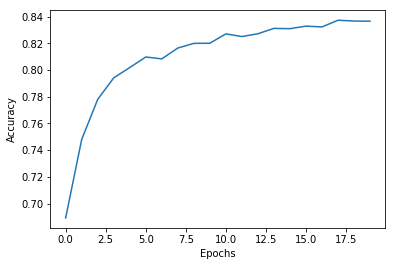

In [6]:
# construct dataset A
order_all = np.random.permutation(img_line) # permutation order for dataset A
tr_a = X_train[:,order_all] # permute pixels
ts_a = X_test[:,order_all]

# train neural network on dataset A
score_a = np.zeros((num_epoch*3,2))
history = model.fit(tr_a, Y_train, batch_size=bsize, epochs=num_epoch, validation_data=(ts_a,Y_test), verbose=0)
score_a[:num_epoch,0] = range(num_epoch)
score_a[:num_epoch,1] = history.history['val_acc']

plt.plot(score_a[:num_epoch,0],score_a[:num_epoch,1])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

## Training network on dataset B

Creating pseudodata from random noise

In [7]:
pseudoX_a = np.random.random_sample(X_train.shape)
pseudoY_a = model.predict(pseudoX_a)
# plot the histogram of output values
# pseudoY_max = np.amax(pseudoY_a, axis=1) # take maximum value of every output vector
# plt.hist(pseudoY_max, bins='auto')  
# plt.title("Distribution of maximum activity nodes")
# plt.show()

Use dataset B together with pseudodata

100% |########################################################################|


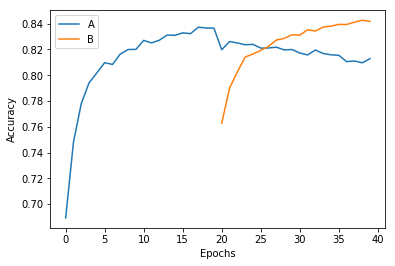

In [8]:
# construct dataset B
order_all = np.random.permutation(img_line) # permutation order for dataset B
tr_b = X_train[:,order_all]
ts_b = X_test[:,order_all]

tr_ab = np.concatenate((tr_b, pseudoX_a), axis=0) # add pseudodata to the training data
Y_ab = np.concatenate((Y_train, pseudoY_a), axis=0) # add pseudotargets to the targets
# shuffle training samples for proper validation set
order_all = np.random.permutation(tr_ab.shape[0])
tr_ab = tr_ab[order_all,:]
Y_ab = Y_ab[order_all,:]

# train on dataset B, test accuracy for datasets A and B
score_b = np.zeros((num_epoch*2,2))
pbar = ProgressBar(maxval=num_epoch).start()
for epoch in range(num_epoch):
    model.fit(tr_ab, Y_ab, batch_size=bsize, epochs=1, verbose=0)
    score = model.evaluate(ts_a, Y_test, verbose=0)
    score_a[epoch+num_epoch,:] = [epoch+num_epoch,score[1]]
    score = model.evaluate(ts_b, Y_test, verbose=0)
    score_b[epoch,:] = [epoch+num_epoch,score[1]]
    pbar.update(epoch+1)
pbar.finish()

plt.plot(score_a[:num_epoch*2,0],score_a[:num_epoch*2,1],label='A')
plt.plot(score_b[:num_epoch,0],score_b[:num_epoch,1],label='B')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Training network on dataset C

100% |########################################################################|


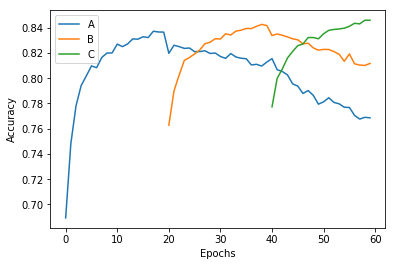

In [9]:
# generate pseudodata
pseudoX_ab = np.random.random_sample(X_train.shape)
pseudoY_ab = model.predict(pseudoX_ab)

# create dataset C
order_all = np.random.permutation(img_line)
tr_c = X_train[:,order_all]
ts_c = X_test[:,order_all]

# add pseudodata to the training data
tr_abc = np.concatenate((tr_c, pseudoX_ab), axis=0) 
Y_abc = np.concatenate((Y_train, pseudoY_ab), axis=0)
# shuffle training samples for proper validation set
order_all = np.random.permutation(tr_abc.shape[0])
tr_abc = tr_abc[order_all,:]
Y_abc = Y_abc[order_all,:]

# train on dataset C, test accuracy for datasets A, B, and C
score_c = np.zeros((num_epoch,2))
pbar = ProgressBar(maxval=num_epoch).start()
for epoch in range(num_epoch):
    model.fit(tr_abc, Y_abc, batch_size=bsize, epochs=1, verbose=0)
    score = model.evaluate(ts_a, Y_test, verbose=0)
    score_a[epoch+num_epoch*2,:] = [epoch+num_epoch*2,score[1]]
    score = model.evaluate(ts_b, Y_test, verbose=0)
    score_b[epoch+num_epoch,:] = [epoch+num_epoch*2,score[1]]
    score = model.evaluate(ts_c, Y_test, verbose=0)
    score_c[epoch,:] = [epoch+num_epoch*2,score[1]]
    pbar.update(epoch+1)
pbar.finish()

plt.plot(score_a[:,0],score_a[:,1],label='A')
plt.plot(score_b[:,0],score_b[:,1],label='B')
plt.plot(score_c[:,0],score_c[:,1],label='C')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
# save training history for furher processing
#np.savez('Pseudorehearsal_0',score_a=score_a,score_b=score_b,score_c=score_c)